# Fifa Screenshot Classifier
---

Model input is a resized screenshot to 224x224

---
## Setup

### Imports

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow Version: {tf.__version__}")

# Built-ins
import os
from pathlib import Path

# Pip installs
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from loguru import logger

# Import local config
from fifa_screenshot_classifier import config
from fifa_screenshot_classifier.model import FifaClassifierNet

Tensorflow Version: 2.0.0


In [2]:
VERBOSE = False

if VERBOSE:
    config.print_config_report()

---
## Helper Functions

In [3]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(config.CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [4]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  
  # The second to last is the class-directory
  return parts[-2] == config.CLASS_NAMES

In [5]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)

  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)

  # resize the image to the desired size.
  return tf.image.resize(img, [config.IMG_WIDTH, config.IMG_HEIGHT])

In [6]:
def process_path(file_path):
  label = get_label(file_path)

  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  
  return img, label

In [7]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(config.BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

## Load using `tf.data`

The above `keras.preprocessing` method is convienient, but has two downsides: 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [8]:
list_train_ds = tf.data.Dataset.list_files(str(config.TRAIN_DIR/'*/*.jpg'))
list_test_ds = tf.data.Dataset.list_files(str(config.TEST_DIR/'*/*.jpg'))

In [9]:
if VERBOSE:
  # Inspect the train and test dataset list
  print("-"*30, " Training", "-"*30)
  for f in list_train_ds.take(5):
    print(f.numpy())

  print("-"*30, " Test Set", "-"*30)
  for f in list_test_ds.take(5):
    print(f.numpy())

Write a short pure-tensorflow function that converts a file paths to an (image_data, label) pair:

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [10]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_train_ds = list_train_ds.map(process_path, num_parallel_calls=AUTOTUNE)

labeled_test_ds = list_test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
if VERBOSE:
  for image, label in labeled_train_ds.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [12]:
train_ds = prepare_for_training(labeled_train_ds)
test_ds = prepare_for_training(labeled_test_ds)

image_batch, label_batch = next(iter(train_ds))

---
## Inspect the Datset

In [13]:
if VERBOSE:
    show_batch(image_batch.numpy(), label_batch.numpy())

---
## Build the Model

In [14]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD

In [15]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=config.INIT_LR, momentum=0.9,
	decay=config.INIT_LR / config.EPOCHS)

model = FifaClassifierNet.build(width=config.IMG_WIDTH, height=config.IMG_HEIGHT, depth=3,
	classes=len(config.CLASS_NAMES))

model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [16]:
if VERBOSE:
    model.summary()

---
## Train the Model

In [19]:
# Train the model
H = model.fit_generator(
    train_ds,
    steps_per_epoch=config.TOTAL_NUM_TRAIN_IMAGES // config.BATCH_SIZE,
    epochs=config.EPOCHS,
    validation_data=test_ds,
    validation_steps=config.TOTAL_NUM_TEST_IMAGES // config.BATCH_SIZE,
    verbose=1
)
print("[INFO] Model finished fitting...")

Epoch 1/25
12/12 [==============================] - 72s 6s/step - loss: 0.2320 - accuracy: 0.9334 - val_loss: 0.2353 - val_accuracy: 0.9375
Epoch 2/25
12/12 [==============================] - 77s 6s/step - loss: 0.1409 - accuracy: 0.9570 - val_loss: 0.2370 - val_accuracy: 0.9375
Epoch 3/25
12/12 [==============================] - 71s 6s/step - loss: 0.1057 - accuracy: 0.9697 - val_loss: 0.2413 - val_accuracy: 0.9375
Epoch 4/25
12/12 [==============================] - 72s 6s/step - loss: 0.0808 - accuracy: 0.9754 - val_loss: 0.2415 - val_accuracy: 0.9375
Epoch 5/25
12/12 [==============================] - 71s 6s/step - loss: 0.0740 - accuracy: 0.9790 - val_loss: 0.2437 - val_accuracy: 0.9375
Epoch 6/25
12/12 [==============================] - 70s 6s/step - loss: 0.0628 - accuracy: 0.9818 - val_loss: 0.2433 - val_accuracy: 0.9375
Epoch 7/25
12/12 [==============================] - 71s 6s/step - loss: 0.0585 - accuracy: 0.9824 - val_loss: 0.2476 - val_accuracy: 0.9375
Epoch 8/25
12/12 [==

---
## Evaluate the network

In [21]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(test_ds, steps=config.TOTAL_NUM_TRAIN_IMAGES // config.BATCH_SIZE)

[INFO] evaluating network...


### Plot the Training Loss & Accuracy

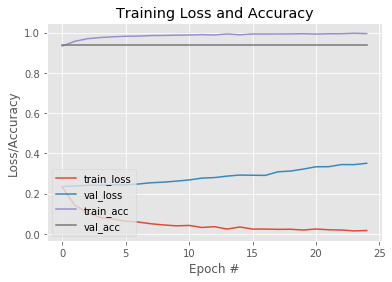

In [24]:
# construct a plot that plots and saves the training history
N = np.arange(0, config.EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(config.TRAINING_PLOT_PATH)

### Save the Model

In [27]:
print(f"[INFO] saving serialized network to {config.MODEL_PATH}")
model.save(str(config.MODEL_PATH))

[INFO] saving serialized network to models/screenshot_classifier.model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/screenshot_classifier.model/assets


In [ ]:
# define the path to the output directory that will store our final
# output with labels/annotations along with the number of images to
# sample
OUTPUT_IMAGE_PATH = os.path.sep.join(["output", "examples"])
SAMPLE_SIZE = 50